In [1]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
usecols = ["Ki (nM)", "IC50 (nM)"]

In [3]:
df = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=usecols,
)

C:\Users\grede\AppData\Local\Temp\ipykernel_21644\2722730526.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [4]:
# clean binding kinetics data
df.replace(" NV,", np.nan, inplace=True)
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(" C", "")
    df[col] = (
        df[col].astype(str).str.replace(">", "").str.replace("<", "").astype(float)
    )

In [5]:
both = df[df["IC50 (nM)"].notna() & df["Ki (nM)"].notna()]
both_log = both.apply(np.log)

In [6]:
# Declares the model
both_log = both_log.rename(columns={"Ki (nM)": "log_Ki", "IC50 (nM)": "log_IC50"})
mod = smf.ols(formula="log_Ki ~ log_IC50", data=both_log)
np.random.seed(2)
res = mod.fit()

In [7]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_Ki   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     6051.
Date:                Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:44:54   Log-Likelihood:                -7438.3
No. Observations:                3177   AIC:                         1.488e+04
Df Residuals:                    3175   BIC:                         1.489e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4933      0.086    -17.399      0.000      -1.662      -1.325
log_IC50       0.9294      0.012     77.790      0.000       0.906       0.953
==============================================================================
Omnibus:                      640.943   Durbin-Watson:                   0.334
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1243.980
Skew:                          -1.215   Prob(JB):                    7.47e-271
Kurtosis:                       4.868   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
res.pvalues

Intercept    7.770882e-65
log_IC50     0.000000e+00
dtype: float64

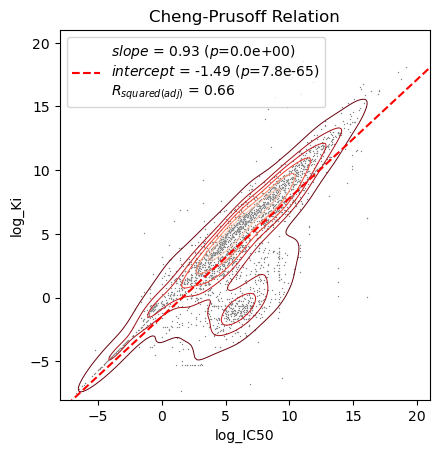

In [9]:
b, a = res.params
fig, axs = plt.subplots(1, 1)

sns.kdeplot(
    both_log[["log_Ki", "log_IC50"]].dropna(),
    y="log_Ki",
    x="log_IC50",
    levels=7,
    cmap="Reds_r",
    fill=False,
    linewidths=0.7,
    ax=axs,
)
sns.scatterplot(
    both_log[["log_Ki", "log_IC50"]].dropna(),
    y="log_Ki",
    x="log_IC50",
    s=1,
    color="grey",
    ax=axs,
)
x = np.linspace(-10, 25, num=50)
p_slope = res.pvalues["log_IC50"]
p_intercept = res.pvalues["Intercept"]
axs.plot(
    x,
    a * x + b,
    color="red",
    linestyle="--",
    label=f"$slope$ = {a:.2f} ($p$={p_slope:.1e})\n$intercept$ = {b:.2f} ($p$={p_intercept:.1e})\n$R_{{squared(adj)}}$ = {res.rsquared_adj:.2f}",
)
axs.set_xlim(-8, 21)
axs.set_ylim(axs.get_xlim())
axs.set_aspect("equal", adjustable="box")
axs.set_title("Cheng-Prusoff Relation")
# axs.set_facecolor("black")
axs.legend()
plt.show()

$log(Ki) = 0.93 * log(IC50) - 1.49$

thus

$Ki = 10^{-(-1.49)}y^{0.93}$

### ANOVA

In [10]:
with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)


cits = pd.DataFrame(citations)

In [11]:
from src.scripts.disease_plotting import *

In [12]:
# main data
usecols = [
    "Target Source Organism According to Curator or DataSource",
    "Article DOI",
    "UniProt (SwissProt) Primary ID of Target Chain",
]
df = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=usecols,
)

# diseases
diseases = load_uniprotid_diseases()
diseases_df = add_keywords_when_comments_missing(diseases).drop(
    columns=["comments", "keywords"]
)
diseases_df = diseases_df.rename(columns={"comments_bfill": "diseases"}).dropna()
diseases_df["Disease Classes"] = diseases_df["diseases"].apply(
    lambda l: [sort_diseases(l_i) for l_i in l]
)
diseases_df = diseases_df.drop(columns="diseases", axis=1)

# citations
with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations_df = pd.DataFrame(citations)

C:\Users\grede\AppData\Local\Temp\ipykernel_21644\3084787973.py:6: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\grede\Documents\EPFL\Master\ADA\Project\ada-2024-project-standarddeviants\src\scripts\disease_plotting.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["comments_bfill"] = df[["comments", "keywords"]].bfill(axis=1)["comments"]


In [13]:
diseases_df

,UniProt (SwissProt) Primary ID of Target Chain,Disease Classes
0,P07949,"[Hirschsprung Disease, Cancer, Neoplasia, Canc..."
1,O60674,"[Budd-Chiari syndrome, Polycythemia vera, Thro..."
2,P00533,"[Cancer, Inflammatory skin and bowel disease]"
3,Q06187,"[Agammaglobulinemia, Agammaglobulinemia]"
4,O60885,[Cornelia de Lange syndrome]
...,...,...
6500,P03923,"[Leber hereditary optic neuropathy, Leber here..."
6503,O08699,[Cancer]
6504,Q8VCC1,[Cancer]
6505,P00698,[Allergen]


In [14]:
citations_df = citations_df.rename({"doi": "Article DOI"}, axis=1)
df = df.merge(citations_df, how="inner", on="Article DOI")
df = df.merge(
    diseases_df, how="inner", on="UniProt (SwissProt) Primary ID of Target Chain"
)
df

,Target Source Organism According to Curator or DataSource,Article DOI,UniProt (SwissProt) Primary ID of Target Chain,citation,Disease Classes
0,Human immunodeficiency virus 1,10.1021/jm9602571,P03367,150.0,[AIDS]
1,Human immunodeficiency virus 1,10.1021/jm9602571,P03367,150.0,[AIDS]
2,Human immunodeficiency virus 1,10.1021/jm9602571,P03367,150.0,[AIDS]
3,Human immunodeficiency virus 1,10.1021/jm9602571,P03367,150.0,[AIDS]
4,Human immunodeficiency virus 1,10.1021/jm9602571,P03367,150.0,[AIDS]
...,...,...,...,...,...
598427,NaN,10.1021/jm050105i,Q14524,34.0,"[Progressive familial heart block 1A, QT syndr..."
598428,NaN,10.1021/jm050105i,Q14524,34.0,"[Progressive familial heart block 1A, QT syndr..."
598429,Homo sapiens,10.1021/jm050105i,Q13936,34.0,"[Timothy syndrome, Brugada syndrome 3, QT synd..."
598430,Homo sapiens,10.1021/jm050105i,Q13936,34.0,"[Timothy syndrome, Brugada syndrome 3, QT synd..."


In [15]:
# cleaning target organism data
in_mapping = {
    "Human immunodeficiency virus": ["immunodeficiency virus", "hiv"],
    "Sars coronavirus": ["severe acute respiratory", "sars"],
    "Human herpes virus": ["herpes"],
    "Homo sapiens": ["h. sapiens"],
    "Mus musculus": ["mouse", "m. musculus"],
    "Rattus norvegicus": ["rattus", "r. norvegicus"],
    "Cavia porcellus": ["cavia"],
    "Hepatitis C": [],
    "Escherichia coli": ["coli"],
    "Caenorhabditis elegans": ["elegans"],
    "Influenza virus": ["influenza"],
    "Oryctolagus cuniculus": ["cuniculus"],
    "Streptococcus pyogenes": ["pyogenes"],
    "Plasmodium falciparum": [],
    "Saccharomyces cerevisiae": ["cervisiae"],
    "Streptococcus pneumoniae": [],
    "Mycobacterium tuberculosis": [],
}

f = lambda x: group_categories(
    str(x),
    in_mapping=in_mapping,
    check_key_for_in_mapping=True,
)

df["Target Source Organism According to Curator or DataSource"] = (
    df["Target Source Organism According to Curator or DataSource"]
    .apply(f)
    .apply(str.capitalize)
    .replace("Nan", np.nan)
)

In [16]:
regression_data = pd.get_dummies(
    df.dropna(), columns=["Target Source Organism According to Curator or DataSource"]
)
regression_data = regression_data.drop(
    columns=[
        "Article DOI",
        "UniProt (SwissProt) Primary ID of Target Chain",
        "Disease Classes",
    ]
)
for colname in regression_data.columns:
    new_name = colname.replace(" ", "_").replace("(", "_").replace(")", "_")
    regression_data = regression_data.rename({colname: new_name}, axis=1)

formula = f"citation ~ " + " + ".join(
    [f"C({col})" for col in regression_data.columns if col != "citation"]
)
mod = smf.ols(formula=formula, data=regression_data)

In [17]:
res = mod.fit()

In [18]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               citation   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     25.72
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           1.46e-91
Time:                        17:46:36   Log-Likelihood:            -2.9121e+06
No. Observations:              396143   AIC:                         5.824e+06
Df Residuals:                  396123   BIC:                         5.824e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================================
                                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                      -3.633e+11   1.65e+13     -0.022      0.982   -3.27e+13     3.2e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Abelson_murine_leukemia_virus)[T.True]              3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Apis_mellifera)[T.True]                             3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Avian_erythroblastosis_virus__strain_es4_)[T.True]  3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Avian_sarcoma_virus)[T.True]                        3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Bos_taurus)[T.True]                                 3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Candida_albicans)[T.True]                           3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Canis_familiaris)[T.True]                           3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Carica_papaya)[T.True]                              3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Fujinami_sarcoma_virus)[T.True]                     3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Gallus_gallus)[T.True]                              3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Hepatitis_c)[T.True]                                3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Hepatitis_gb_virus_b)[T.True]                       3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Curator_or_DataSource_Homo_sapiens)[T.True]                               3.633e+11   1.65e+13      0.022      0.982    -3.2e+13    3.27e+13
C(Target_Source_Organism_According_to_Cu

In [19]:
df = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=["IC50 (nM)", "Article DOI"],
)

C:\Users\grede\AppData\Local\Temp\ipykernel_21644\1229032991.py:1: DtypeWarning: Columns (9,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [20]:
df.replace(" NV,", np.nan, inplace=True)

df["IC50 (nM)"] = df["IC50 (nM)"].astype(str).str.replace(" C", "")
df["IC50 (nM)"] = (
    df["IC50 (nM)"].astype(str).str.replace(">", "").str.replace("<", "").astype(float)
)

In [21]:
# citations
with open("../src/data/citations.json", "r") as f:
    citations = json.load(f)
citations_df = pd.DataFrame(citations)
citations_df = citations_df.rename({"doi": "Article DOI"}, axis=1)

In [22]:
# merge both
df = df.merge(citations_df, how="inner", on="Article DOI")
df

,IC50 (nM),Article DOI,citation
0,NaN,10.1021/jm9602571,150.0
1,NaN,10.1021/jm9602571,150.0
2,NaN,10.1021/jm9602571,150.0
3,NaN,10.1021/jm9602571,150.0
4,NaN,10.1021/jm9602571,150.0
...,...,...,...
1553602,53.0,10.1016/j.bmcl.2005.08.100,24.0
1553603,15.0,10.1016/j.bmcl.2005.08.100,24.0
1553604,38.0,10.1016/j.bmcl.2005.08.100,24.0
1553605,27.0,10.1016/j.bmcl.2005.08.100,24.0


In [23]:
df = df.rename({"IC50 (nM)": "IC50"}, axis=1)
df["logIC50"] = df["IC50"].apply(np.log10).replace(-np.inf, np.nan)
df["logcit"] = df["citation"].apply(np.log10)

In [24]:
df["logIC50"]
df["logIC50"].describe()

count    919823.000000
mean          2.854840
std           1.525360
min          -4.301030
25%           1.707570
50%           2.954243
75%           4.000000
max          14.000000
Name: logIC50, dtype: float64

In [25]:
mod = smf.ols(formula="citation ~ logIC50", data=df)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               citation   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     555.5
Date:                Thu, 14 Nov 2024   Prob (F-statistic):          8.93e-123
Time:                        17:48:07   Log-Likelihood:            -5.3333e+06
No. Observations:              919777   AIC:                         1.067e+07
Df Residuals:                  919775   BIC:                         1.067e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.0990      0.177    227.110      0.0

c:\Users\grede\anaconda3\envs\ada\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


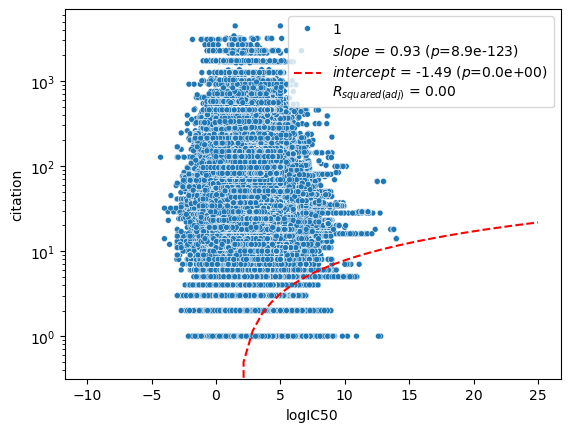

In [26]:
x = np.linspace(-10, 25, num=50)
p_slope = res.pvalues["logIC50"]
p_intercept = res.pvalues["Intercept"]
sns.scatterplot(df, y="citation", x="logIC50", size=1)
plt.plot(
    x,
    a * x + b,
    color="red",
    linestyle="--",
    label=f"$slope$ = {a:.2f} ($p$={p_slope:.1e})\n$intercept$ = {b:.2f} ($p$={p_intercept:.1e})\n$R_{{squared(adj)}}$ = {res.rsquared_adj:.2f}",
)
plt.legend()
plt.yscale("log")
plt.show()